Данный ноутбук представляет собой небольшое исследование применения алгоритмов многокритериальной оптимизации для задачи оптимизации криптовалютного портфеля.

# Crypto Portfolio Optimization

In [1]:
# Библиотеки для многокритериальной оптимизации
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA

from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

# Библиотека для рассчета гиперобъема
from deap.tools._hypervolume import hv

# Библиотека для рассчета расстояний между точками
from scipy.spatial.distance import pdist

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from scipy.stats import norm

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для работы с датой и временем
from datetime import datetime, timedelta

# Библиотека для работы с информацией о криптовалютах
import yfinance as yf

sns.set_style('darkgrid')

In [2]:
# Загрузим историю изменения цены криптовалюты

# Список интересующих криптовалют можно изменять. Все доступные тикеры можно посмотреть на https://finance.yahoo.com/crypto/
TICKERS = ["TON11419-USD", "SUI20947-USD",'ETH-USD', "LINK-USD", "APT21794-USD", "FET-USD", "TAO22974-USD", 'BTC-USD']

data: pd.DataFrame = yf.download(TICKERS, start="2024-05-01", end="2024-08-29", progress=True)["Adj Close"]
returns: pd.DataFrame = data.pct_change().dropna()

# Для рассчета ожидаемой доходности и ковариационной матрицы используется медианная доходность
expected_returns: pd.Series = returns.median()
cov_matrix: pd.DataFrame = returns.cov()

[*********************100%***********************]  8 of 8 completed


In [3]:
# Библиотека pymoo использует объектно-ориентированный подход, поэтому нам нужно создать класс, который будет представлять нашу задачу
# В данном классе мы реализуем методы для нормализации весов, рассчета ожидаемой доходности и Value at Risk

class CryptoPortfolioProblem(ElementwiseProblem):
    """Класс, представляющий задачу многокритериальной оптимизации криптовалютного портфеля."""
    
    DEFAULT_CONFIDENCE_LEVEL: float = 0.95
    
    def __init__(self, elementwise=True, confidence_level=DEFAULT_CONFIDENCE_LEVEL, **kwargs):
        """
        Инициализация задачи оптимизации портфеля.
        
        Аргументы:
            elementwise (bool): Использовать ли поэлементную оценку
            confidence_level (float): Уровень доверия для расчета VaR
            **kwargs: Дополнительные аргументы, передаваемые в родительский класс
        """
        self.confidence_level = confidence_level
        n_assets = len(TICKERS)
        
        super().__init__(
            elementwise=elementwise,
            n_var=n_assets,
            n_obj=2,
            xl=0,
            xu=10
        )

    def _normalize_weights(self, x: np.ndarray) -> np.ndarray:
        """Нормализация долей, чтобы их сумма равнялась 1."""
        return np.round(x / np.sum(x), 3)

    def _evaluate(self, x: np.ndarray, out: dict, *args, **kwargs) -> None:
        """
        Оценка целевых функций портфеля.
        
        Аргументы:
            x: Веса портфеля
            out: Словарь для хранения результатов
        """
        weights = self._normalize_weights(x)
        profit = self._calc_portfolio_return(weights)
        risk = self._calc_value_at_risk(weights)
        
        # В pymoo все целевые функции минимизируются, поэтому мы используем отрицательную прибыль
        out["F"] = [-profit, risk]

    def _calc_portfolio_return(self, weights: np.ndarray) -> float:
        """Расчет ожидаемой доходности портфеля."""
        return float(np.sum(expected_returns * weights))

    def _calc_portfolio_stats(self, weights: np.ndarray) -> tuple[float, float]:
        """Расчет среднего значения и стандартного отклонения портфеля."""
        portfolio_mean = np.sum(expected_returns * weights)
        portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
        return portfolio_mean, portfolio_std

    def _calc_value_at_risk(self, weights: np.ndarray) -> float:
        """
        Расчет Value at Risk (VaR) для портфеля.
        
        Возвращает:
            float: VaR портфеля при заданном уровне доверия
        """
        mean, std = self._calc_portfolio_stats(weights)
        z_score = norm.ppf(1 - self.confidence_level)
        return -(mean + z_score * std)
    
problem = CryptoPortfolioProblem()

# Применяем алгоритмы многокритериальной оптимизации

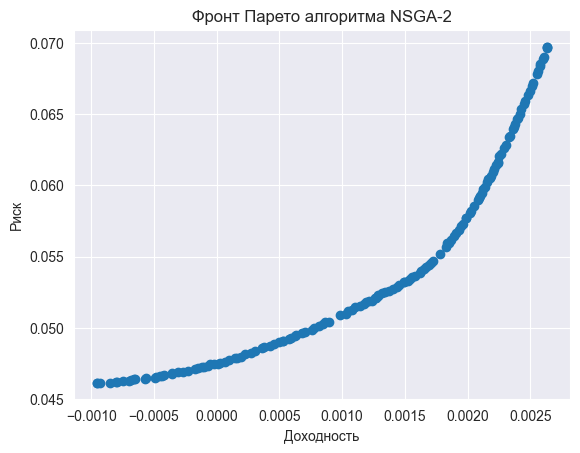

In [5]:
# Первый алгоритм, который мы протестируем - это NSGA-2.
# В данном случае мы не используем параметры по умолчанию, а явно задаем размер популяции и количество поколений

nsga2 = NSGA2(pop_size=150)
mutation = PolynomialMutation(eta=20, prob_var=0.2)

nsga2_result = minimize(
    problem,
    nsga2,
    ('n_gen', 1500),
    verbose=False,
    mutation=mutation
)

# Визуализируем результаты
plt.scatter(-nsga2_result.F[:, 0], nsga2_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма NSGA-2")
plt.show()

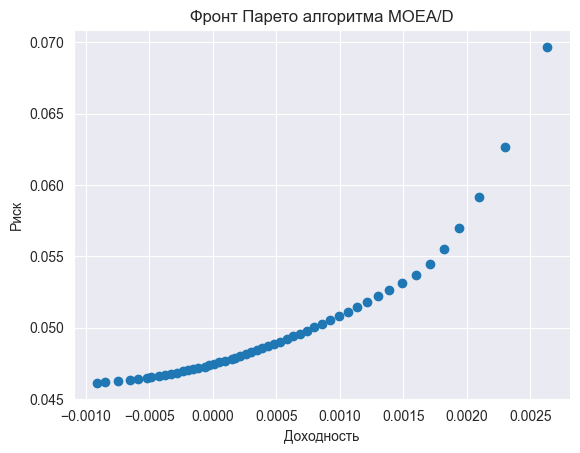

In [6]:
# Второй алгоритм, который мы протестируем - это MOEA/D.

# get_reference_directions генерирует направления для поиска MOEA/D
ref_dirs = get_reference_directions('uniform', 2, n_partitions=50)

moea_d = MOEAD(
    ref_dirs,
    n_neighbors=20,
)

moea_d_result = minimize(problem,
            moea_d,
            ('n_gen', 1500),
            verbose=False
            )

plt.scatter(-moea_d_result.F[:, 0], moea_d_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма MOEA/D")
plt.show()

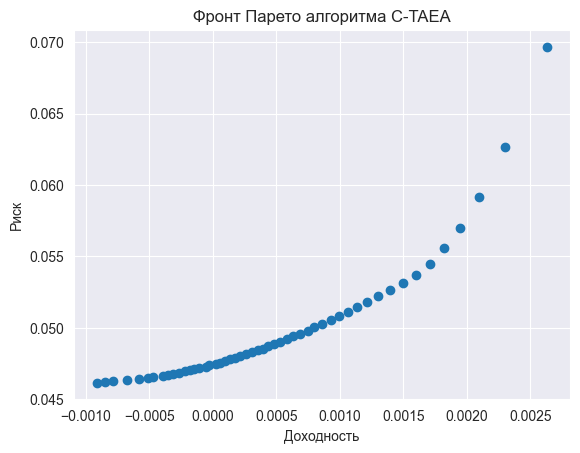

In [7]:
# Третий алгоритм, который мы протестируем - это C-TAEA.

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

c_taea = CTAEA(ref_dirs=ref_dirs)

c_taea_res = minimize(problem,
            c_taea,
            ('n_gen', 1500),
            verbose=False
            )

plt.scatter(-c_taea_res.F[:, 0], c_taea_res.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма C-TAEA")
plt.show()

# Оценка полученных Парето-фронтов

Превоначально применим метрику Hypervolume для оценки качества полученных Парето-фронтов.
В качестве reference point возьмём точку с отрицательной доходностью (-0.5) и высоким риском (1.0)

In [8]:
reference_point = np.array([0.5, 1.0])

In [9]:
print('NSGA-2 hypervolume: ', hv.hypervolume(nsga2_result.F, reference_point))  
print('MOEA/D hypervolume: ', hv.hypervolume(moea_d_result.F, reference_point))
print('C-TAEA hypervolume: ', hv.hypervolume(c_taea_res.F, reference_point))

NSGA-2 hypervolume:  0.4794286485481696
MOEA/D hypervolume:  0.4794230965378569
C-TAEA hypervolume:  0.47942167390877943


Теперь применим метрику Spacing для оценки расстояния между точками Парето-фронта.

In [11]:
def spacing(points: np.ndarray) -> float:
    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        other_points = np.delete(points, i, axis=0)
        distances[i] = np.min(np.linalg.norm(other_points - point, axis=1))
    # Среднее расстояние
    mean_distance = np.mean(distances)
    # Вычисление Spacing
    spacing = np.sqrt(np.mean((distances - mean_distance) ** 2))
    return spacing

print('NSGA-2 spacing: ', spacing(nsga2_result.F))
print('MOEA/D spacing: ', spacing(moea_d_result.F))
print('C-TAEA spacing: ', spacing(c_taea_res.F))

NSGA-2 spacing:  8.088054785578817e-05
MOEA/D spacing:  0.0010908913244168973
C-TAEA spacing:  0.00109092933054642


И теперь рассчитаем среднее евклидово расстояние между точками Парето-фронта для оценки разнообразия Парето-фронтов.

In [12]:
def average_distance(points: np.ndarray) -> float:
    distances = pdist(points, metric='euclidean')
    return np.mean(distances)

print('NSGA-2 average distance: ', average_distance(nsga2_result.X))
print('MOEA/D average distance: ', average_distance(moea_d_result.X))
print('C-TAEA average distance: ', average_distance(c_taea_res.X))

NSGA-2 average distance:  5.21235405588715
MOEA/D average distance:  4.784367469224798
C-TAEA average distance:  6.194479725669801


# Анализ предоставленных решений

In [13]:
# Сейчас решение представлено в виде чисел от 0 до 10. Нам нужно нормализовать их так, чтобы их сумма равнялась 1.
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    res = np.round(weights / weights.sum(axis=1)[:, np.newaxis], 3)
    return res

In [14]:
# Соберём данные в единую таблицу

nsga2_data = pd.DataFrame(normalize_weights(nsga2_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(nsga2_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
nsga2_data['algorithm'] = 'NSGA-2'

moea_d_data = pd.DataFrame(normalize_weights(moea_d_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(moea_d_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
moea_d_data['algorithm'] = 'MOEA/D'

c_taea_data = pd.DataFrame(normalize_weights(c_taea_res.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(c_taea_res.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
c_taea_data['algorithm'] = 'C-TAEA'

all_data = pd.concat([nsga2_data, moea_d_data, c_taea_data])
all_data['expected_profit'] = -all_data['expected_profit']
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm
0,0.0,0.835,0.001,0.0,0.0,0.0,0.0,0.161,-0.000958,0.046130,NSGA-2
1,0.0,0.000,0.000,0.0,0.0,0.0,0.0,1.000,0.002638,0.069732,NSGA-2
4,0.0,0.000,0.426,0.0,0.0,0.0,0.0,0.574,0.001779,0.055213,NSGA-2
5,0.0,0.199,0.396,0.0,0.0,0.0,0.0,0.405,0.000985,0.050884,NSGA-2
6,0.0,0.211,0.411,0.0,0.0,0.0,0.0,0.376,0.000898,0.050436,NSGA-2
...,...,...,...,...,...,...,...,...,...,...,...
46,0.0,0.408,0.282,0.0,0.0,0.0,0.0,0.307,0.000309,0.048272,C-TAEA
47,0.0,0.389,0.279,0.0,0.0,0.0,0.0,0.329,0.000397,0.048533,C-TAEA
48,0.0,0.382,0.275,0.0,0.0,0.0,0.0,0.341,0.000438,0.048716,C-TAEA
49,0.0,0.000,0.269,0.0,0.0,0.0,0.0,0.730,0.002093,0.059182,C-TAEA


In [15]:
all_data.groupby('algorithm', as_index=False).mean()

,algorithm,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk
0,C-TAEA,0.000020,0.382706,0.250765,0.000000,0.000000,0.0,0.000000,0.364176,0.000483,0.049906
1,MOEA/D,0.000000,0.383549,0.251471,0.000000,0.000000,0.0,0.000000,0.362941,0.000478,0.049908
2,NSGA-2,0.000007,0.224986,0.248634,0.000014,0.000124,0.0,0.000007,0.524993,0.001166,0.054402


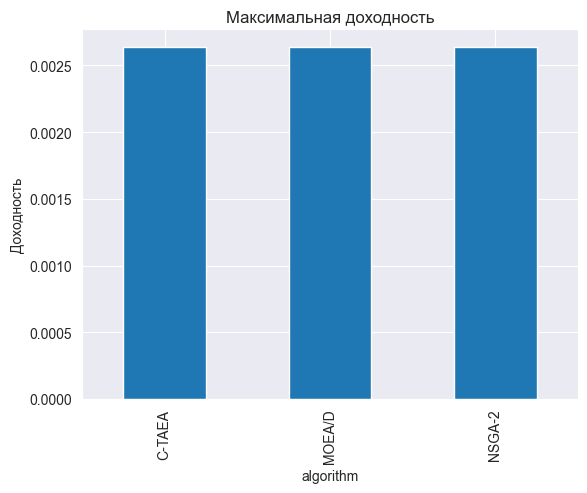

In [16]:
all_data.groupby('algorithm')['expected_profit'].max().plot(kind='bar')
plt.title('Максимальная доходность')
plt.ylabel('Доходность')

plt.show()

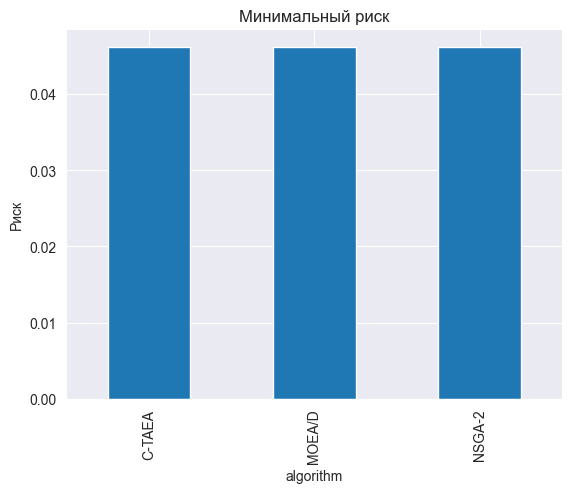

In [17]:
all_data.groupby('algorithm')['risk'].min().plot(kind='bar')
plt.title('Минимальный риск')
plt.ylabel('Риск')
plt.show()

In [18]:
# Создадим функцию для получения цены на указанную дату
def get_price_on_date(ticker_symbol: str, date_str: str) -> float | None:
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
        
        data = yf.Ticker(ticker_symbol).history(start=date_str, end=end_date)
        
        if data.empty:
            print(f"No data available for {ticker_symbol} on {date_str}")
            return None
            
        return round(float(data['Close'].iloc[0]), 2)
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        return None

In [19]:
def calculate_portfolio_price(portfolio: dict[str, float],
                            start_date: str, end_date: str, 
                            start_sum: float = 100) -> float:
    
    portfolio_parts = {ticker: float((start_sum * part) / get_price_on_date(ticker, start_date)) 
                        for ticker, part in portfolio.items()}
    
    end_prices = {ticker: get_price_on_date(ticker, end_date) * portfolio_parts[ticker] for ticker in portfolio_parts.keys()}
    return round(sum(end_prices.values()), 2)

In [20]:
all_data['end_price'] = all_data.apply(lambda row: calculate_portfolio_price(row[TICKERS].to_dict(), '2024-10-01', '2024-11-08'), axis=1)
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
0,0.0,0.835,0.001,0.0,0.0,0.0,0.0,0.161,-0.000958,0.046130,NSGA-2,129.02
1,0.0,0.000,0.000,0.0,0.0,0.0,0.0,1.000,0.002638,0.069732,NSGA-2,125.82
4,0.0,0.000,0.426,0.0,0.0,0.0,0.0,0.574,0.001779,0.055213,NSGA-2,123.75
5,0.0,0.199,0.396,0.0,0.0,0.0,0.0,0.405,0.000985,0.050884,NSGA-2,124.75
6,0.0,0.211,0.411,0.0,0.0,0.0,0.0,0.376,0.000898,0.050436,NSGA-2,124.48
...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.0,0.408,0.282,0.0,0.0,0.0,0.0,0.307,0.000309,0.048272,C-TAEA,125.82
47,0.0,0.389,0.279,0.0,0.0,0.0,0.0,0.329,0.000397,0.048533,C-TAEA,125.76
48,0.0,0.382,0.275,0.0,0.0,0.0,0.0,0.341,0.000438,0.048716,C-TAEA,125.87
49,0.0,0.000,0.269,0.0,0.0,0.0,0.0,0.730,0.002093,0.059182,C-TAEA,124.39


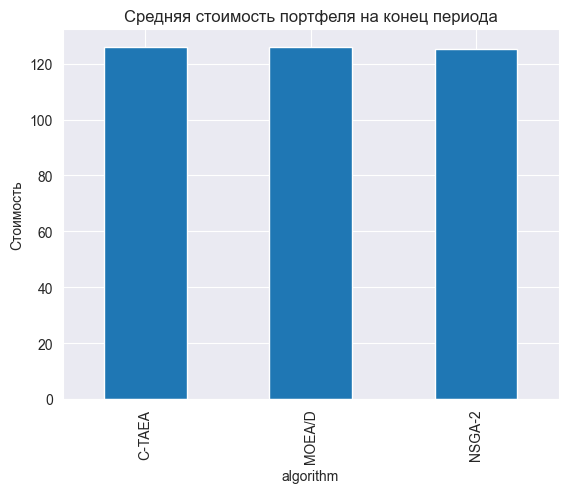

In [21]:
all_data.groupby('algorithm')['end_price'].mean().plot(kind='bar')
plt.title('Средняя стоимость портфеля на конец периода')
plt.ylabel('Стоимость')
plt.show()

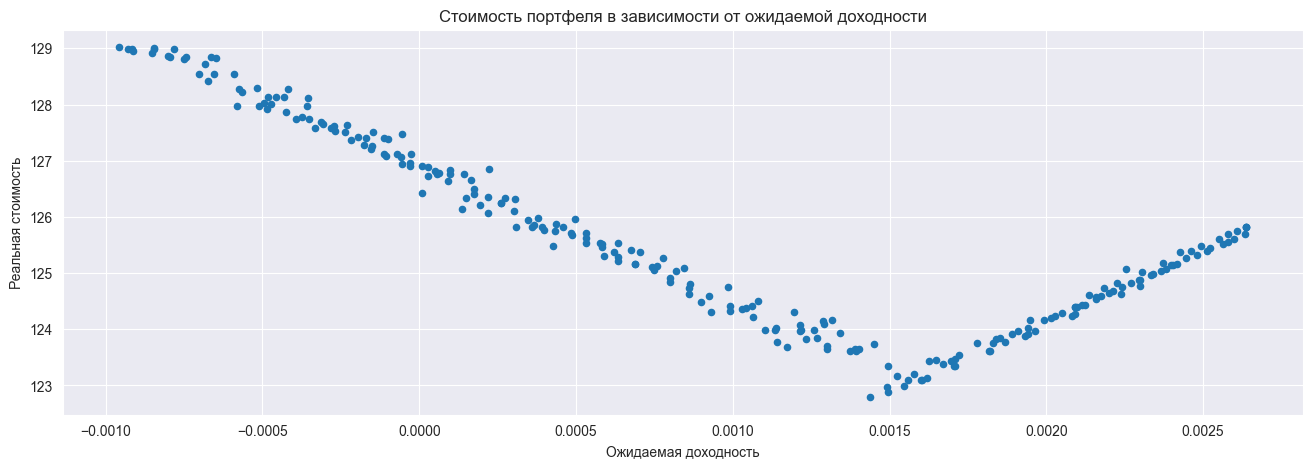

In [22]:
all_data.sort_values(by='end_price', ascending=False)[['expected_profit', 'end_price']]\
    .plot(kind='scatter', x='expected_profit', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от ожидаемой доходности')
plt.xlabel('Ожидаемая доходность')
plt.ylabel('Реальная стоимость')
plt.show()

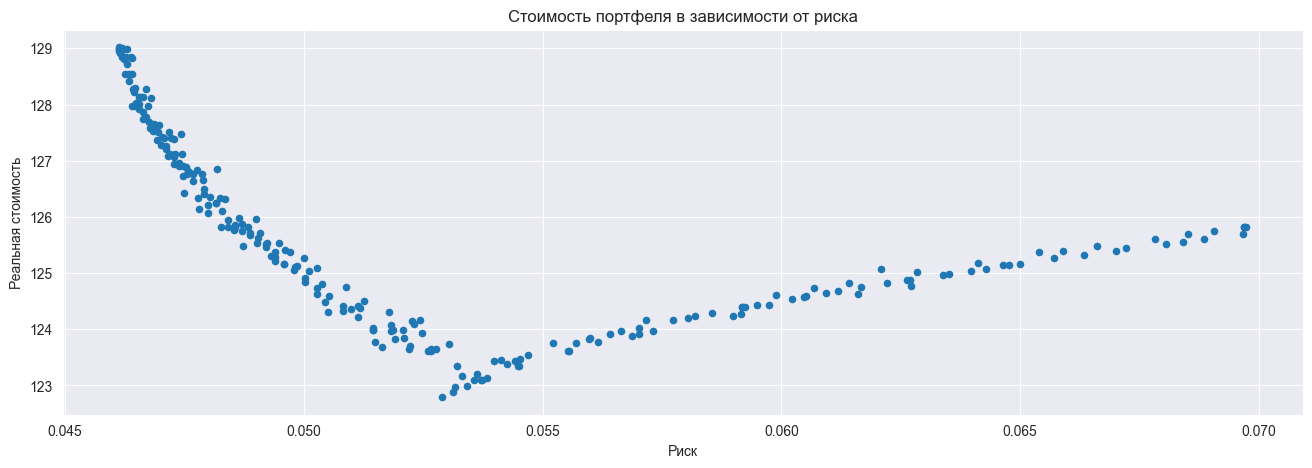

In [23]:
all_data.sort_values(by='end_price', ascending=False)[['risk', 'end_price']]\
    .plot(kind='scatter', x='risk', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от риска')
plt.xlabel('Риск')
plt.ylabel('Реальная стоимость')
plt.show()